In [1]:
import torch
import torchaudio

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

2.0.1
2.0.2
cpu


In [11]:
import IPython
import matplotlib.pyplot as plt

In [5]:
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)


def text_to_sequence(text):
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]


text = "Hello world! Text to speech!"
print(text_to_sequence(text))

[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15, 2, 11, 31, 16, 35, 31, 11, 31, 26, 11, 30, 27, 16, 16, 14, 19, 2]


In [6]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

text = "Hello world! Text to speech!"
processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15,  2, 11, 31, 16, 35, 31, 11,
         31, 26, 11, 30, 27, 16, 16, 14, 19,  2]])
tensor([28], dtype=torch.int32)


In [8]:
# Phonem based encoding

bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()

text = "Hello world! Text to speech!"
with torch.inference_mode():
    processed, lengths = processor(text)

print(processed)
print(lengths)

100%|██████████| 63.6M/63.6M [00:32<00:00, 2.04MB/s]


tensor([[54, 20, 65, 69, 11, 92, 44, 65, 38,  2, 11, 81, 40, 64, 79, 81, 11, 81,
         20, 11, 79, 77, 59, 37,  2]])
tensor([25], dtype=torch.int32)


In [9]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['HH', 'AH', 'L', 'OW', ' ', 'W', 'ER', 'L', 'D', '!', ' ', 'T', 'EH', 'K', 'S', 'T', ' ', 'T', 'AH', ' ', 'S', 'P', 'IY', 'CH', '!']


torch.Size([1, 80, 244])


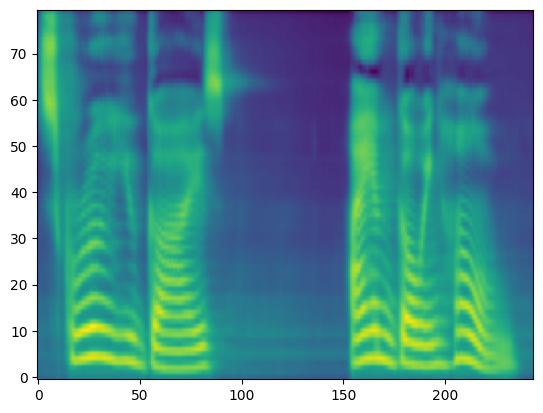

In [26]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

text = "Screw you guys! I am going home."

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, _ = tacotron2.infer(processed, lengths)
    print(spec.shape)

_ = plt.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")

torch.Size([80, 161])
torch.Size([80, 203])
torch.Size([80, 177])


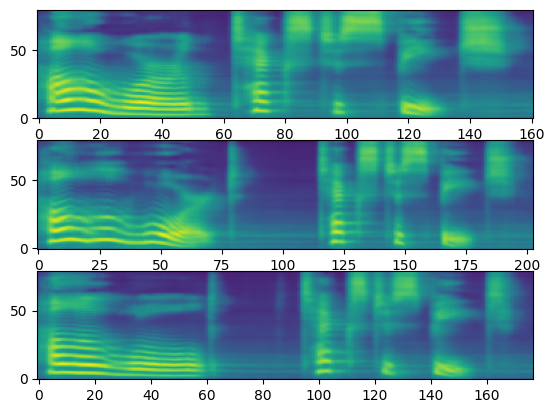

In [13]:
def plot():
    fig, ax = plt.subplots(3, 1)
    for i in range(3):
        with torch.inference_mode():
            spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
        print(spec[0].shape)
        ax[i].imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")


plot()

In [59]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "Screw you guys! I am going home."

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

100%|██████████| 63.6M/63.6M [00:14<00:00, 4.46MB/s]
Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth" to /Users/xkal/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth
100%|██████████| 107M/107M [00:08<00:00, 13.1MB/s] 
Downloading: "https://download.pytorch.org/torchaudio/models/wavernn_10k_epochs_8bits_ljspeech.pth" to /Users/xkal/.cache/torch/hub/checkpoints/wavernn_10k_epochs_8bits_ljspeech.pth
100%|██████████| 16.7M/16.7M [00:01<00:00, 13.0MB/s]


torch.Size([1, 62150])


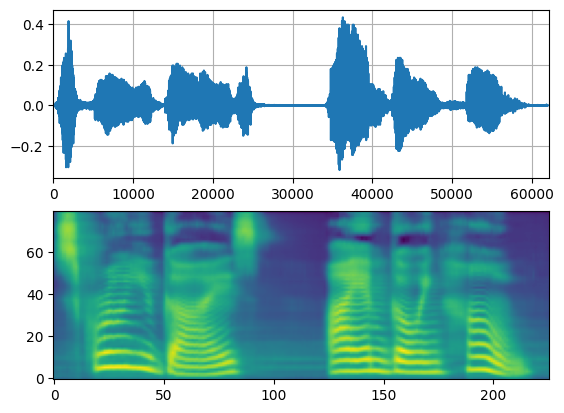

In [60]:
def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()
    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    print(waveforms.shape)
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)


plot(waveforms, spec, vocoder.sample_rate)

In [61]:
torchaudio.save(src=waveforms, sample_rate=vocoder.sample_rate, filepath='audio.wav')

In [47]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

# get_text_processor: convert to phonem
processor = bundle.get_text_processor()
# tacotron : phonem to spectogram
tacotron = bundle.get_tacotron2()
# vocoder : spectogram to waveforms
vocoder = bundle.get_vocoder()

# to device
tacotron = tacotron.to(device=device)
vocoder = vocoder.to(device=device)


text = "I am not your guy, buddy."

with torch.inference_mode():
    # text to phonem
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    # Phonem to Spectogram
    spec, spec_lengths, _ = tacotron.infer(processed, lengths)
    print(f'spec_lengths : {spec_lengths}')
    # Spectogram to Waveforms
    waveforms, lengths = vocoder(spec, spec_lengths)
    print(f'wave_length: {lengths}')

spec_lengths : tensor([185], dtype=torch.int32)
wave_length: tensor([50875], dtype=torch.int32)


In [48]:
IPython.display.Audio(waveforms[0:1], rate=vocoder.sample_rate)

In [49]:
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)

/usr/local/lib/python3.8/site-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /Users/xkal/.cache/torch/hub/torchhub.zip
/Users/xkal/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  wa

In [50]:
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)

Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth" to /Users/xkal/.cache/torch/hub/checkpoints/nvidia_waveglowpyt_fp32_20190306.pth


torch.Size([1, 47360])


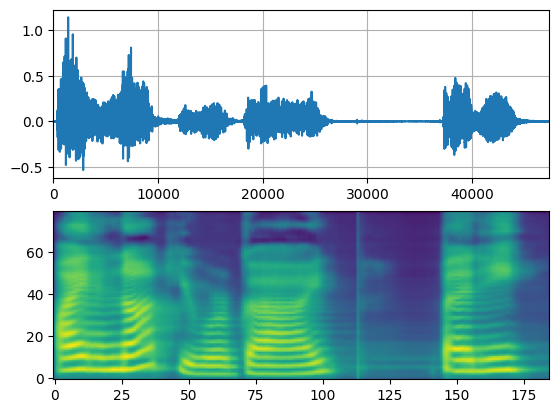

In [51]:
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

plot(waveforms, spec, 22050)

In [52]:
print(waveforms.shape)

torch.Size([1, 47360])
